# Image Grain (Low-Freq Noise) Removal Using White Noise Filter

#### lfnfilter uses AWGN noise filter to remove image grain

In [1]:
import time
import numpy as np
import skimage.io
import skimage.filters
import matplotlib.pyplot as plt
import bmcnn
import LFden

### Read noisy image and other parameters

BMCNN can be replaced by any AWGN denoiser


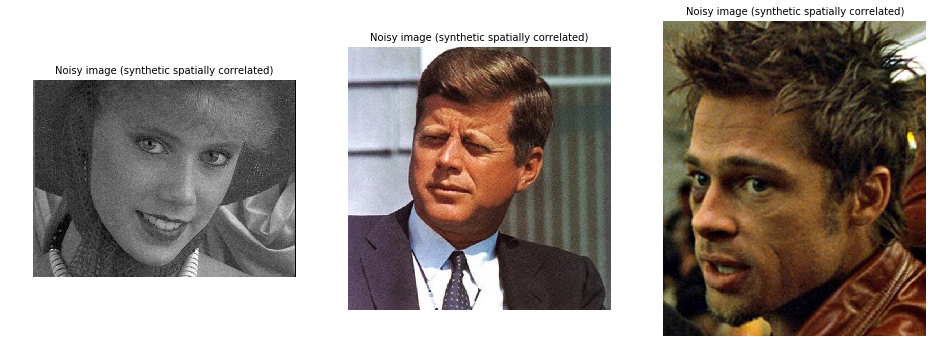

In [2]:
# algorithm parameters
sigma_a = 0.6
l = 1
N = 8


####   AWGN denoiser ####
def bmcnn_denoiser(I, sigma):
    bmcnn_out = np.zeros_like(I)
    Ii = I/255*(15.0/sigma)
    bmcnn.predict(handle, Ii, bmcnn_out)
    return np.clip(bmcnn_out*255/(15.0/sigma), 0, 255)

# initialize bmcnn denoiser
handle = bmcnn.open('../models/bmcnn_16.bin')


# read noisy image
I = np.float32(skimage.io.imread('../dataset/I04_noisy.png'))
# read original image
I_o = np.float32(skimage.io.imread('../dataset/I04.png'))

#------------  noise variance calculation -----------
noise = I_o-I
n_max = np.max(np.abs(noise))
noise_f = skimage.filters.gaussian(noise/n_max, sigma_a, mode='reflect')
sigma_w = np.std(noise_f*n_max) #Variance of noise at l=1
sigma_n = np.std(noise) #Variance of noise at l=0
#----------------Proposed Framework------------------

plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1)
plt.title("Noisy image (synthetic spatially correlated)", fontsize=10)
plt.axis('off')
plt.imshow(skimage.color.gray2rgb(np.uint8(I)))

I2 = skimage.io.imread('../dataset/JFK.png')
plt.subplot(1, 3, 2)
plt.title("Noisy image (synthetic spatially correlated)", fontsize=10)
plt.axis('off')
plt.imshow(I2)

I3 = skimage.io.imread('../dataset/fight_club.jpg')
I3=I3[0:576,656:656+480,:]
plt.subplot(1, 3, 3)
plt.title("Noisy image (synthetic spatially correlated)", fontsize=10)
plt.axis('off')
plt.imshow(I3)

print("BMCNN can be replaced by any AWGN denoiser")
plt.show()

### Denoising framework

In [3]:
def gray2rgb(im_rgb,img_gray):     
    ycbcr = skimage.color.rgb2ycbcr(im_rgb[:,:,:3])
    ycbcr[:,:, 0] = img_gray
    rgb = skimage.color.ycbcr2rgb(ycbcr)
    rgb[rgb<0]=0
    rgb[rgb>1]=1
    return np.uint8(rgb*255)

def lfnfilter_test(I, sigma_w, sigma_n, sigma_a, I_rgb):
    start_time = time.time()
    I_h, A1 = LFden.downsample(I, sigma_a, 2**l)
    A1_f = bmcnn_denoiser(A1, sigma_w)
    #*********** LF denoiser ****************
    I_F = LFden.LFdenoiser(I, A1_f, I_h, sigma_w)
    elapsed = time.time()-start_time
    print('elapsed time of proposed is %2.3f seconds'%elapsed)
    #---------------denoiser all pass---------
    start_time = time.time()
    y_allpass = bmcnn_denoiser(I, sigma_n)
    elapsed = time.time()-start_time
    print('elapsed time of all-pass (normal BMCNN) is %2.3f seconds'%elapsed)

    plt.figure(figsize=(16, 16))
    plt.subplot(1, 2, 1)
    plt.title("Denoised by BMCNN", fontsize=10)
    plt.axis('off')
    plt.imshow(gray2rgb(I_rgb, np.uint8(y_allpass)))

    plt.subplot(1, 2, 2)
    plt.title("Denoised by LFNfilter, BMCNN (high-pass)", fontsize=10)
    plt.axis('off')
    plt.imshow(gray2rgb(I_rgb, I_F))
    plt.show()

elapsed time of proposed is 0.211 seconds
elapsed time of all-pass (normal BMCNN) is 0.736 seconds


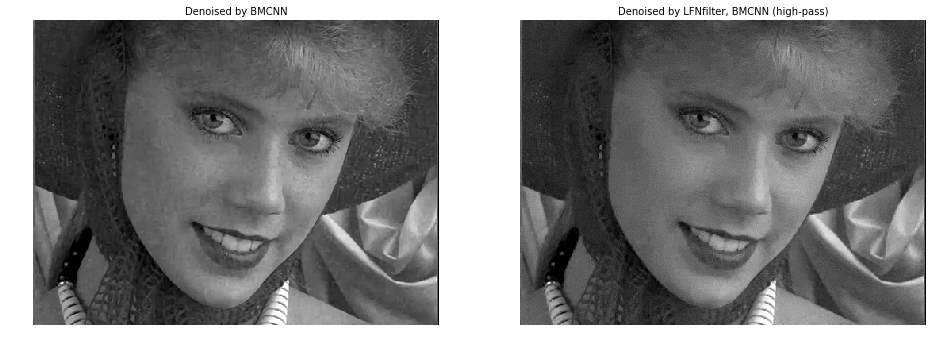

In [4]:
lfnfilter_test(I, sigma_w, sigma_n, sigma_a, skimage.color.gray2rgb(np.uint8(I)))

elapsed time of proposed is 0.502 seconds
elapsed time of all-pass (normal BMCNN) is 1.967 seconds


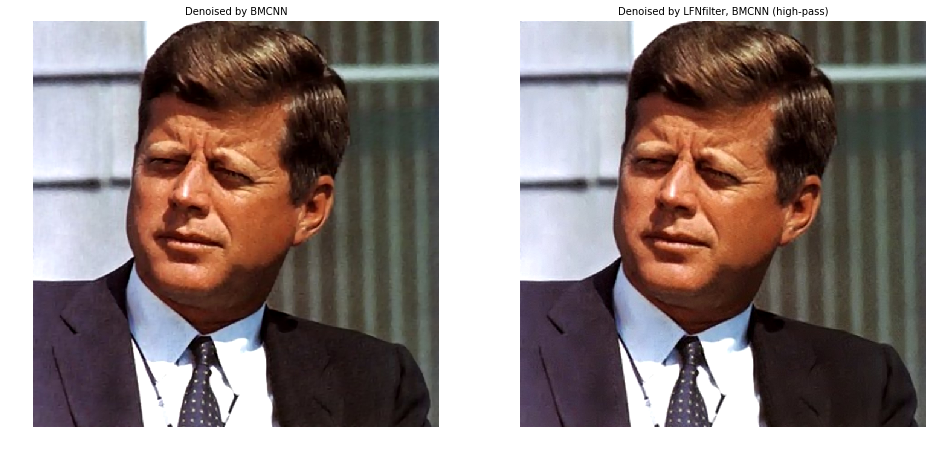

In [5]:
I = np.float32(skimage.color.rgb2gray(I2))*255
sigma_w = 5.0 #Variance of noise at l=1
sigma_n = 8.0 #Variance of noise at l=0
lfnfilter_test(I, sigma_w, sigma_n, sigma_a, I2)

elapsed time of proposed is 0.390 seconds
elapsed time of all-pass (normal BMCNN) is 1.175 seconds


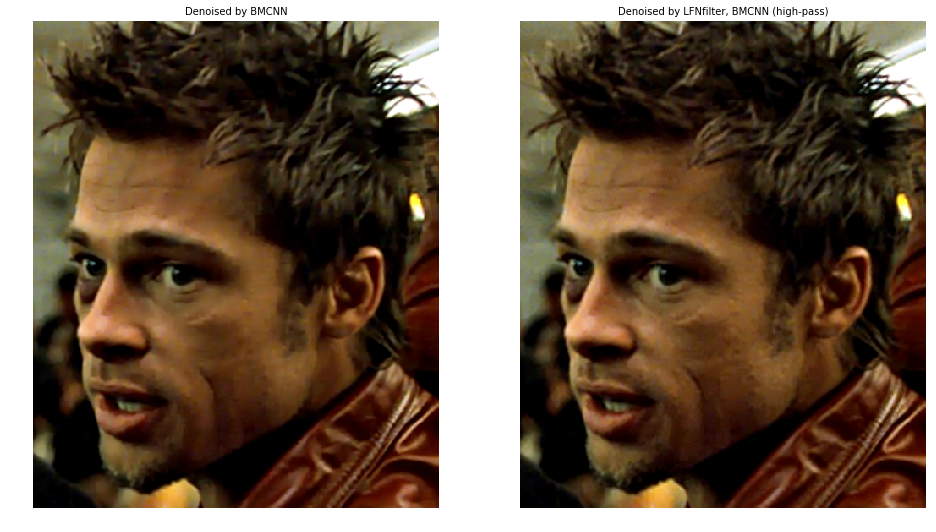

In [6]:
I = np.float32(skimage.color.rgb2gray(I3))*255
sigma_w = 4 #Variance of noise at l=1
sigma_n = 8 #Variance of noise at l=0
lfnfilter_test(I, sigma_w, sigma_n, sigma_a, I3)